2. Theoretical Background
2.1 Sampling Theorem (Nyquist-Shannon)
The sampling theorem states that a continuous-time signal can be perfectly reconstructed from its samples if:

The signal is band-limited to frequency fmaxf_{max}
fmax​
The sampling frequency fs≥2fmaxf_s ≥ 2f_{max}
fs​≥2fmax​ (Nyquist rate)


2.2 Speech Signal Characteristics
Speech signals typically have:

Fundamental frequency (F0): 80-500 Hz
Formant frequencies: F1 (300-1000 Hz), F2 (800-2500 Hz), F3 (1500-3500 Hz)
Bandwidth: ~4 kHz for telephone quality, ~8 kHz for good quality

2.3 Reconstruction Methods
Zero-Order Hold (ZOH):
xr(t)=x[n] for nT≤t<(n+1)Tx_r(t) = x[n] \text{ for } nT ≤ t < (n+1)Txr​(t)=x[n] for nT≤t<(n+1)T
Linear Interpolation:
xr(t)=x[n]+t−nTT(x[n+1]−x[n])x_r(t) = x[n] + \frac{t-nT}{T}(x[n+1]-x[n])xr​(t)=x[n]+Tt−nT​(x[n+1]−x[n])
2.4 Source-Filter Model
Speech production can be modeled as:

S(z)=E(z)⋅H(z)S(z) = E(z) \cdot H(z)S(z)=E(z)⋅H(z)
Where:

E(z)E(z)
E(z): Excitation signal (voiced/unvoiced)

H(z)H(z)
H(z): Vocal tract filter

S(z)S(z)
S(z): Speech signal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.io import wavfile
from scipy.interpolate import interp1d
import librosa
import soundfile as sf
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
def generate_synthetic_speech(duration=2, fs=16000):
    """
    Generate a synthetic speech-like signal using the source-filter model
    """
    t = np.linspace(0, duration, int(fs * duration))
    
    # Generate excitation signal (mix of periodic and noise)
    f0 = 150  # Fundamental frequency
    voiced_excitation = np.sin(2 * np.pi * f0 * t)
    noise_excitation = np.random.normal(0, 0.1, len(t))
    
    # Mix voiced and unvoiced segments
    excitation = np.zeros_like(t)
    for i in range(0, len(t), int(0.1 * fs)):  # 100ms segments
        segment_end = min(i + int(0.1 * fs), len(t))
        if np.random.random() > 0.3:  # 70% voiced
            excitation[i:segment_end] = voiced_excitation[i:segment_end]
        else:  # 30% unvoiced
            excitation[i:segment_end] = noise_excitation[i:segment_end]
    
    return excitation, t, fs

# Generate synthetic speech
excitation, t_orig, fs_orig = generate_synthetic_speech()

# Create vocal tract filter (formant frequencies)
def create_vocal_tract_filter(fs, formants=[800, 1200, 2500], bandwidths=[100, 120, 150]):
    """
    Create vocal tract filter with specified formant frequencies
    """
    # Design filter with formant resonances
    num = [1]
    den = [1]
    
    for f, bw in zip(formants, bandwidths):
        # Convert to digital filter
        w = 2 * np.pi * f / fs
        bw_norm = 2 * np.pi * bw / fs
        
        # Second-order resonant filter
        r = 1 - bw_norm / 2
        num_temp = [1, 0, 0]
        den_temp = [1, -2 * r * np.cos(w), r**2]
        
        # Cascade filters
        num = np.convolve(num, num_temp)
        den = np.convolve(den, den_temp)
    
    return num, den

# Apply vocal tract filter
num, den = create_vocal_tract_filter(fs_orig)
speech_signal = signal.lfilter(num, den, excitation)

# Normalize
speech_signal = speech_signal / np.max(np.abs(speech_signal))

print(f"Generated speech signal: {len(speech_signal)} samples at {fs_orig} Hz")

Generated speech signal: 32000 samples at 16000 Hz


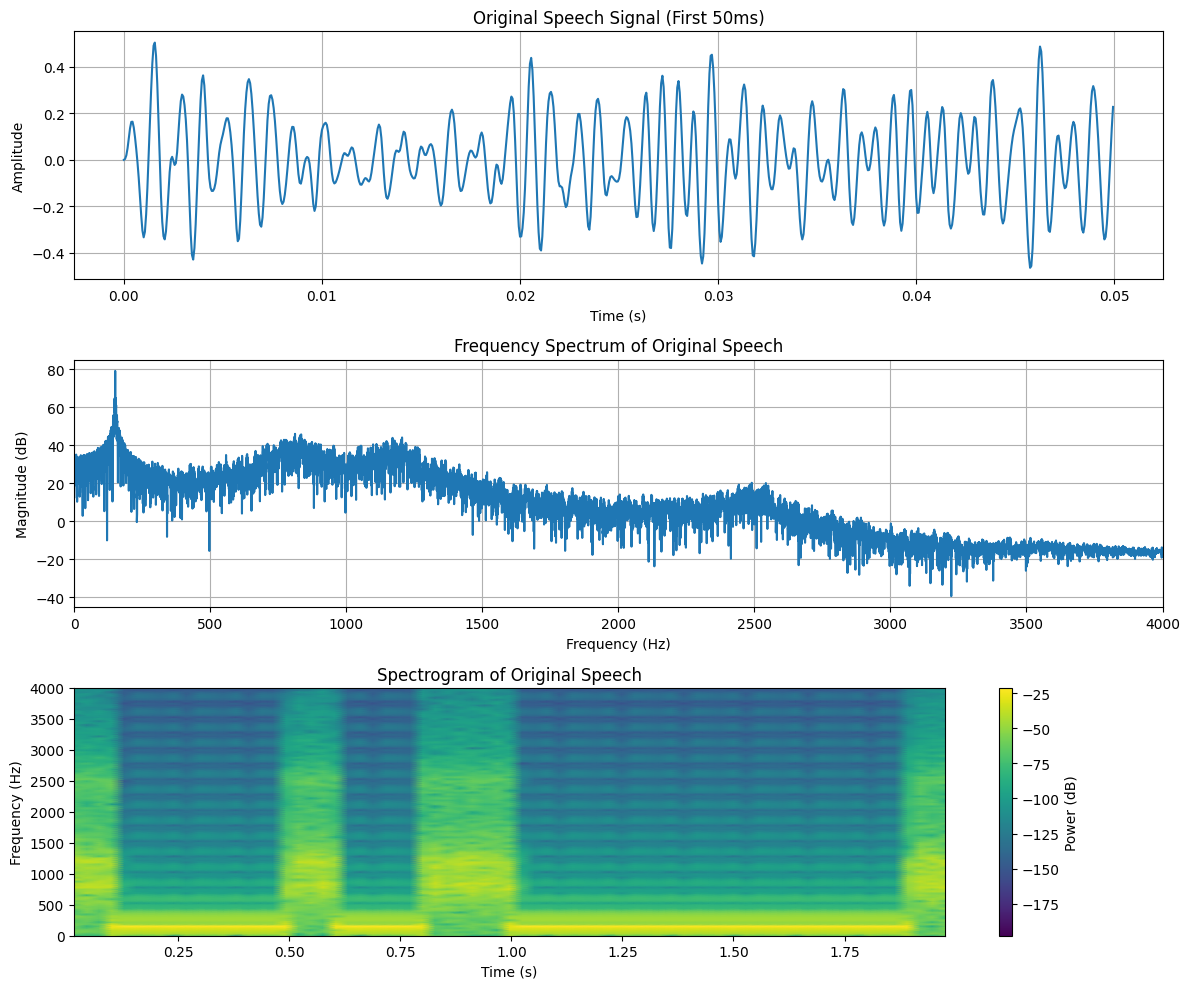

In [3]:
# Plot original speech signal
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Time domain
axes[0].plot(t_orig[:int(0.05*fs_orig)], speech_signal[:int(0.05*fs_orig)])
axes[0].set_title('Original Speech Signal (First 50ms)')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True)

# Frequency domain
freqs = np.fft.fftfreq(len(speech_signal), 1/fs_orig)
fft_speech = np.fft.fft(speech_signal)
axes[1].plot(freqs[:len(freqs)//2], 20*np.log10(np.abs(fft_speech[:len(freqs)//2])))
axes[1].set_title('Frequency Spectrum of Original Speech')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude (dB)')
axes[1].set_xlim([0, 4000])
axes[1].grid(True)

# Spectrogram
f_spec, t_spec, Sxx = signal.spectrogram(speech_signal, fs_orig, nperseg=512)
im = axes[2].pcolormesh(t_spec, f_spec, 10*np.log10(Sxx), shading='gouraud')
axes[2].set_title('Spectrogram of Original Speech')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Frequency (Hz)')
axes[2].set_ylim([0, 4000])
plt.colorbar(im, ax=axes[2], label='Power (dB)')

plt.tight_layout()
plt.show()

# Audio playback
display(Audio(speech_signal, rate=fs_orig))

In [10]:
def sample_signal(input_signal, fs_original, fs_new):
    """
    Sample signal at new sampling rate
    """
    # Calculate decimation factor
    decimation_factor = int(fs_original / fs_new)
    
    # Anti-aliasing filter before downsampling
    nyquist = fs_new / 2
    normalized_cutoff = nyquist / (fs_original / 2)
    
    if normalized_cutoff < 1.0:
        # Design low-pass filter
        b, a = signal.butter(8, normalized_cutoff, btype='low')
        filtered_signal = signal.lfilter(b, a, input_signal)
    else:
        filtered_signal = input_signal
    
    # Downsample
    sampled_signal = filtered_signal[::decimation_factor]
    t_sampled = np.arange(len(sampled_signal)) / fs_new
    
    return sampled_signal, t_sampled

# Define different sampling rates
sampling_rates = [8000, 4000, 2000, 1000]  # Hz
sampled_signals = {}
time_vectors = {}

# Sample at different rates
for fs in sampling_rates:
    sampled_sig, t_samp = sample_signal(speech_signal, fs_orig, fs)
    sampled_signals[fs] = sampled_sig
    time_vectors[fs] = t_samp
    print(f"Sampled at {fs} Hz: {len(sampled_sig)} samples")

Sampled at 8000 Hz: 16000 samples
Sampled at 4000 Hz: 8000 samples
Sampled at 2000 Hz: 4000 samples
Sampled at 1000 Hz: 2000 samples


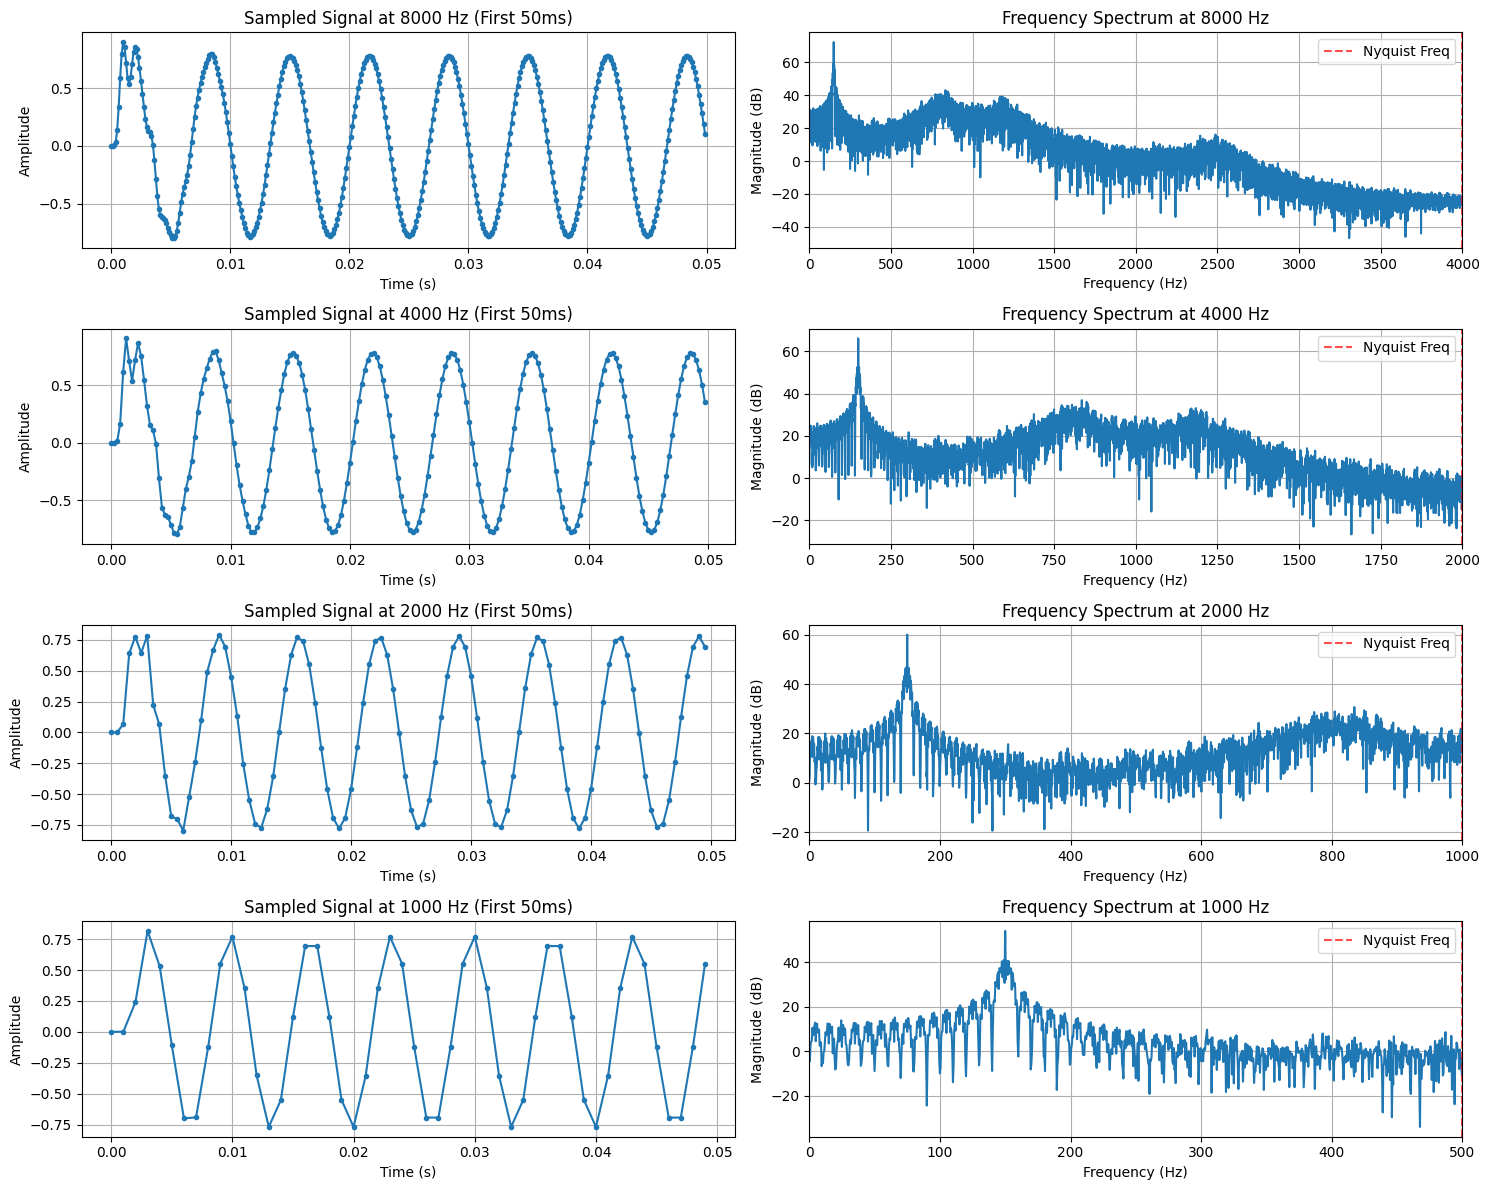

In [11]:
# Plot sampled signals
fig, axes = plt.subplots(len(sampling_rates), 2, figsize=(15, 12))

for i, fs in enumerate(sampling_rates):
    # Time domain (first 50ms)
    duration_50ms = 0.05
    samples_50ms = int(duration_50ms * fs)
    
    axes[i, 0].plot(time_vectors[fs][:samples_50ms], sampled_signals[fs][:samples_50ms], 'o-', markersize=3)
    axes[i, 0].set_title(f'Sampled Signal at {fs} Hz (First 50ms)')
    axes[i, 0].set_xlabel('Time (s)')
    axes[i, 0].set_ylabel('Amplitude')
    axes[i, 0].grid(True)
    
    # Frequency domain
    freqs = np.fft.fftfreq(len(sampled_signals[fs]), 1/fs)
    fft_sampled = np.fft.fft(sampled_signals[fs])
    axes[i, 1].plot(freqs[:len(freqs)//2], 20*np.log10(np.abs(fft_sampled[:len(freqs)//2])))
    axes[i, 1].set_title(f'Frequency Spectrum at {fs} Hz')
    axes[i, 1].set_xlabel('Frequency (Hz)')
    axes[i, 1].set_ylabel('Magnitude (dB)')
    axes[i, 1].set_xlim([0, fs/2])
    axes[i, 1].grid(True)
    
    # Mark Nyquist frequency
    axes[i, 1].axvline(fs/2, color='red', linestyle='--', alpha=0.7, label='Nyquist Freq')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [12]:
def zero_order_hold_reconstruction(samples, t_samples, fs_original):
    """
    Reconstruct signal using zero-order hold
    """
    # Create time vector for reconstruction
    t_reconstructed = np.linspace(0, t_samples[-1], int(t_samples[-1] * fs_original))
    
    # Zero-order hold: hold each sample value until next sample
    reconstructed = np.zeros_like(t_reconstructed)
    
    for i in range(len(samples) - 1):
        # Find indices in reconstructed time vector for current sample interval
        start_idx = np.searchsorted(t_reconstructed, t_samples[i])
        end_idx = np.searchsorted(t_reconstructed, t_samples[i + 1])
        reconstructed[start_idx:end_idx] = samples[i]
    
    # Handle last sample
    start_idx = np.searchsorted(t_reconstructed, t_samples[-1])
    reconstructed[start_idx:] = samples[-1]
    
    return reconstructed, t_reconstructed

# Reconstruct using ZOH
zoh_reconstructed = {}
zoh_time_vectors = {}

for fs in sampling_rates:
    recon_sig, t_recon = zero_order_hold_reconstruction(
        sampled_signals[fs], time_vectors[fs], fs_orig
    )
    zoh_reconstructed[fs] = recon_sig
    zoh_time_vectors[fs] = t_recon
    print(f"ZOH reconstruction at {fs} Hz: {len(recon_sig)} samples")

ZOH reconstruction at 8000 Hz: 31998 samples
ZOH reconstruction at 4000 Hz: 31996 samples
ZOH reconstruction at 2000 Hz: 31992 samples
ZOH reconstruction at 1000 Hz: 31984 samples


In [13]:
def linear_interpolation_reconstruction(samples, t_samples, fs_original):
    """
    Reconstruct signal using linear interpolation
    """
    # Create time vector for reconstruction
    t_reconstructed = np.linspace(0, t_samples[-1], int(t_samples[-1] * fs_original))
    
    # Use scipy's interp1d for linear interpolation
    interpolator = interp1d(t_samples, samples, kind='linear', 
                          bounds_error=False, fill_value='extrapolate')
    reconstructed = interpolator(t_reconstructed)
    
    return reconstructed, t_reconstructed

# Reconstruct using linear interpolation
linear_reconstructed = {}
linear_time_vectors = {}

for fs in sampling_rates:
    recon_sig, t_recon = linear_interpolation_reconstruction(
        sampled_signals[fs], time_vectors[fs], fs_orig
    )
    linear_reconstructed[fs] = recon_sig
    linear_time_vectors[fs] = t_recon
    print(f"Linear interpolation reconstruction at {fs} Hz: {len(recon_sig)} samples")

Linear interpolation reconstruction at 8000 Hz: 31998 samples
Linear interpolation reconstruction at 4000 Hz: 31996 samples
Linear interpolation reconstruction at 2000 Hz: 31992 samples
Linear interpolation reconstruction at 1000 Hz: 31984 samples


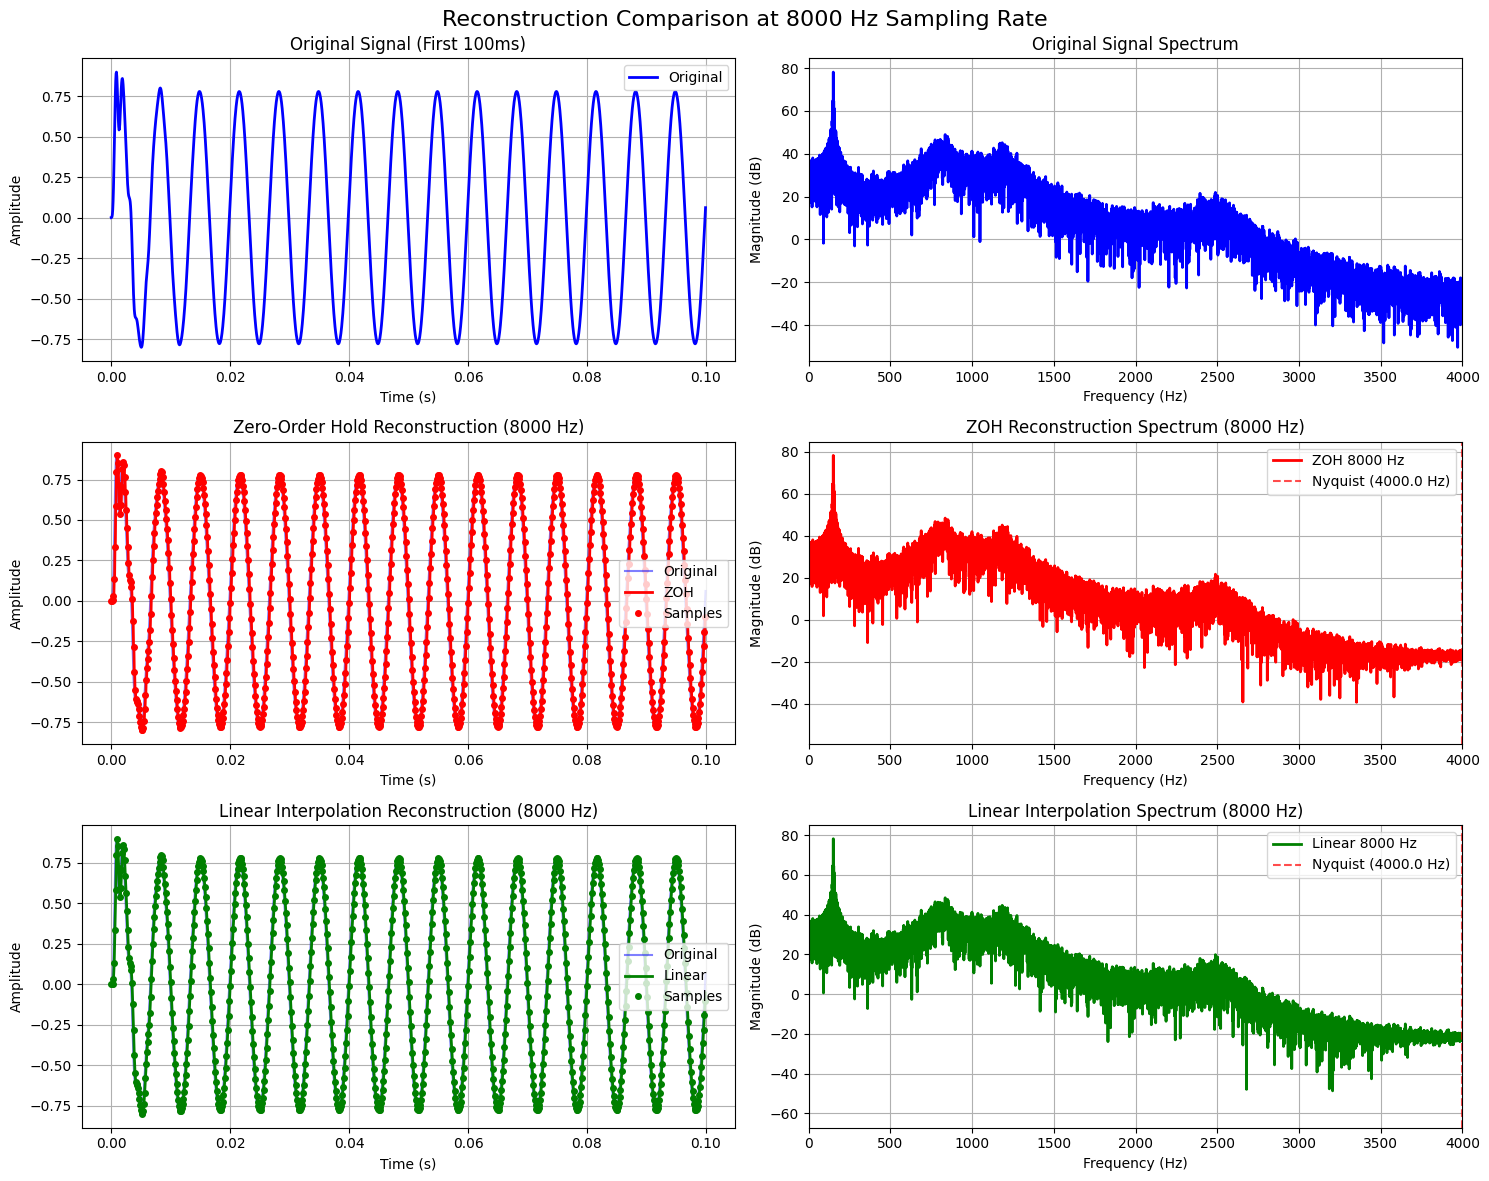

Completed analysis for 8000 Hz sampling rate
--------------------------------------------------


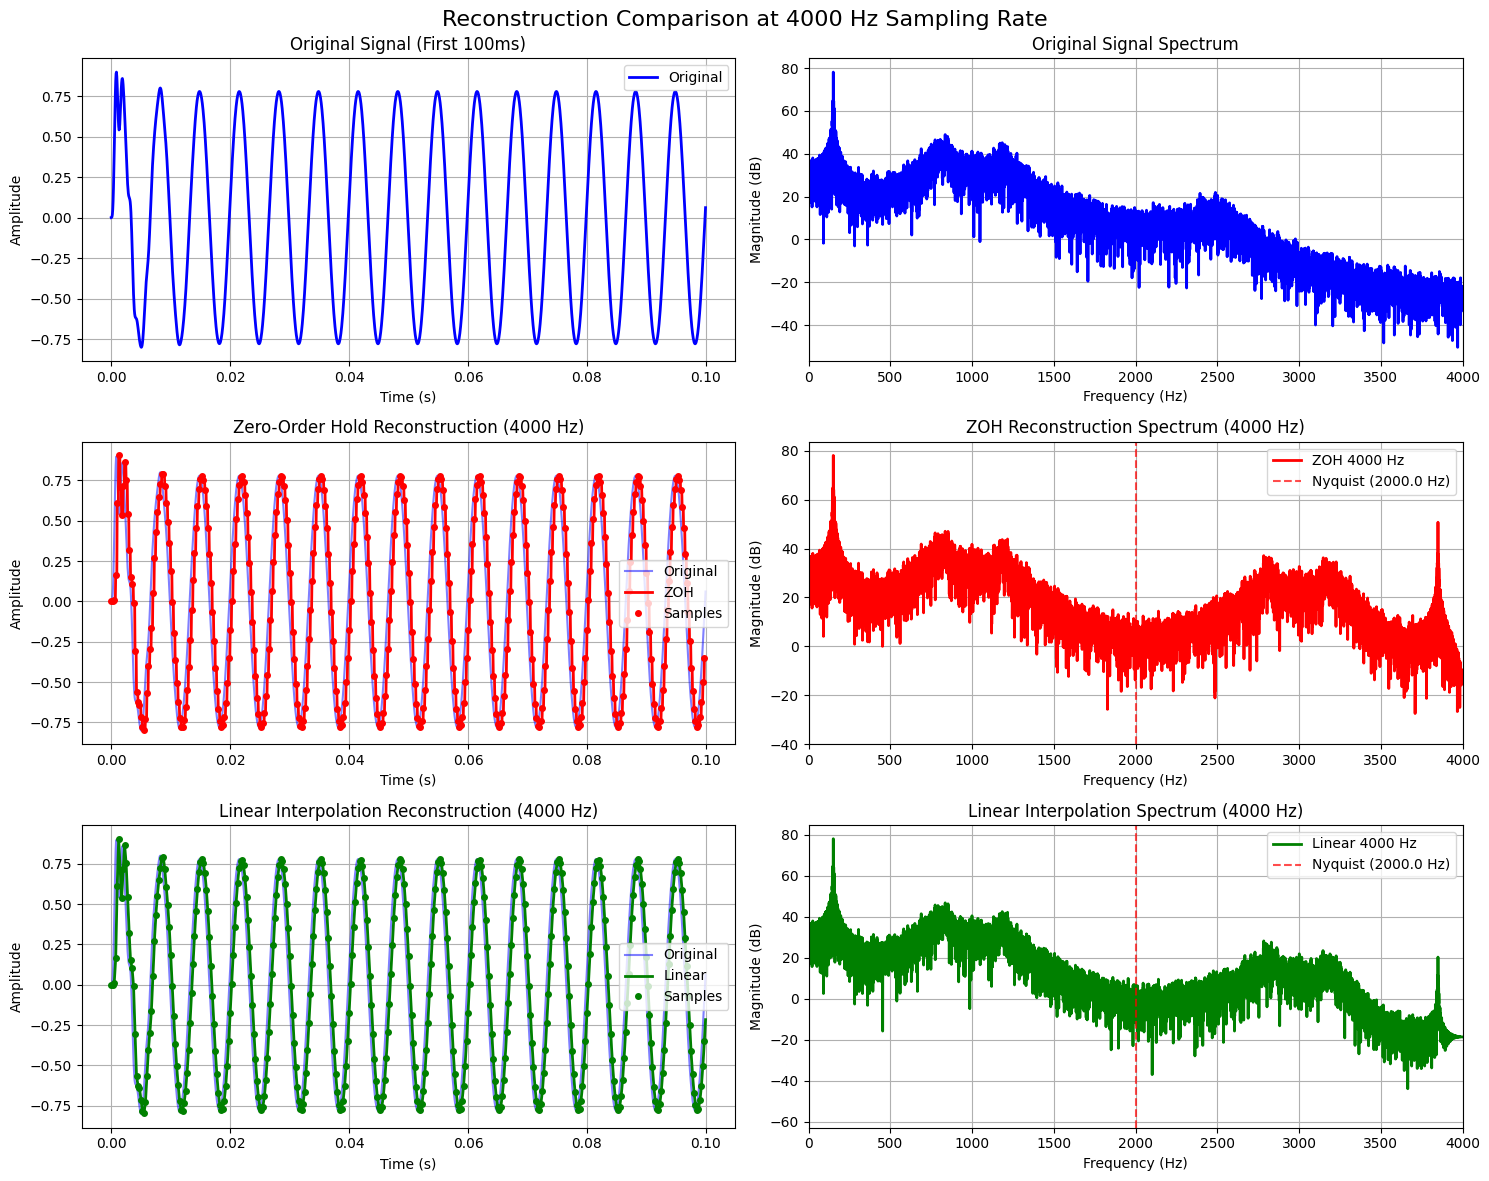

Completed analysis for 4000 Hz sampling rate
--------------------------------------------------


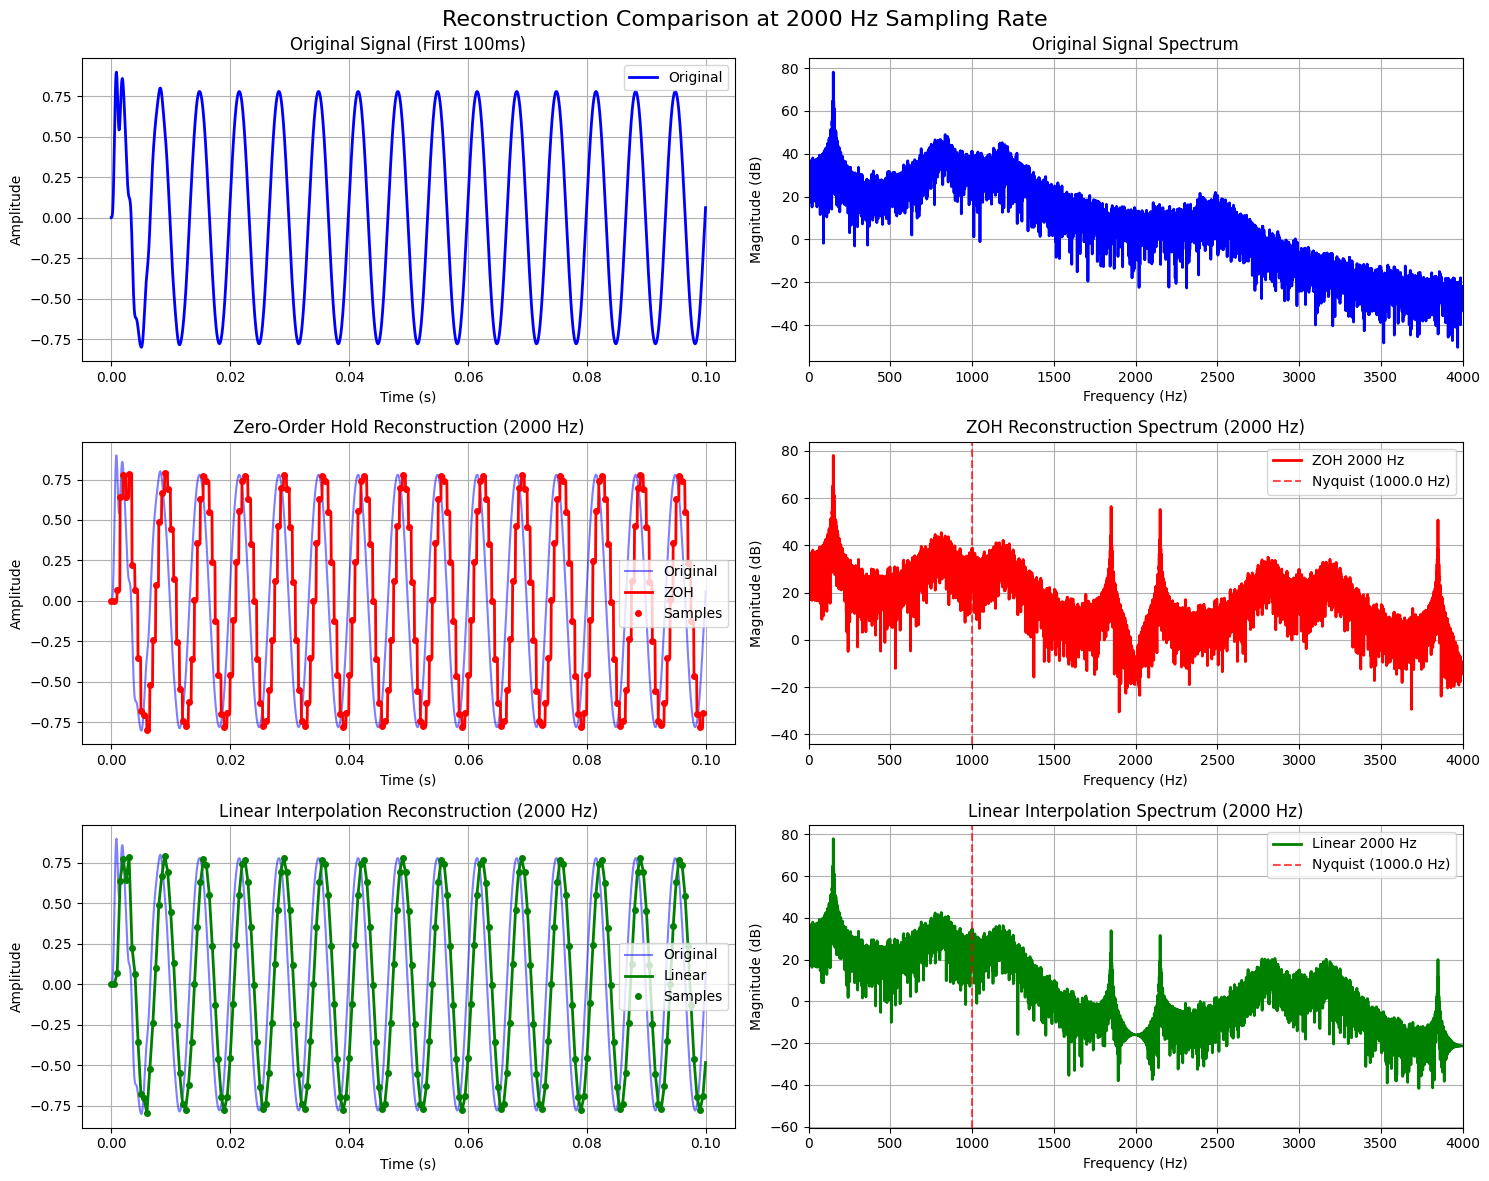

Completed analysis for 2000 Hz sampling rate
--------------------------------------------------


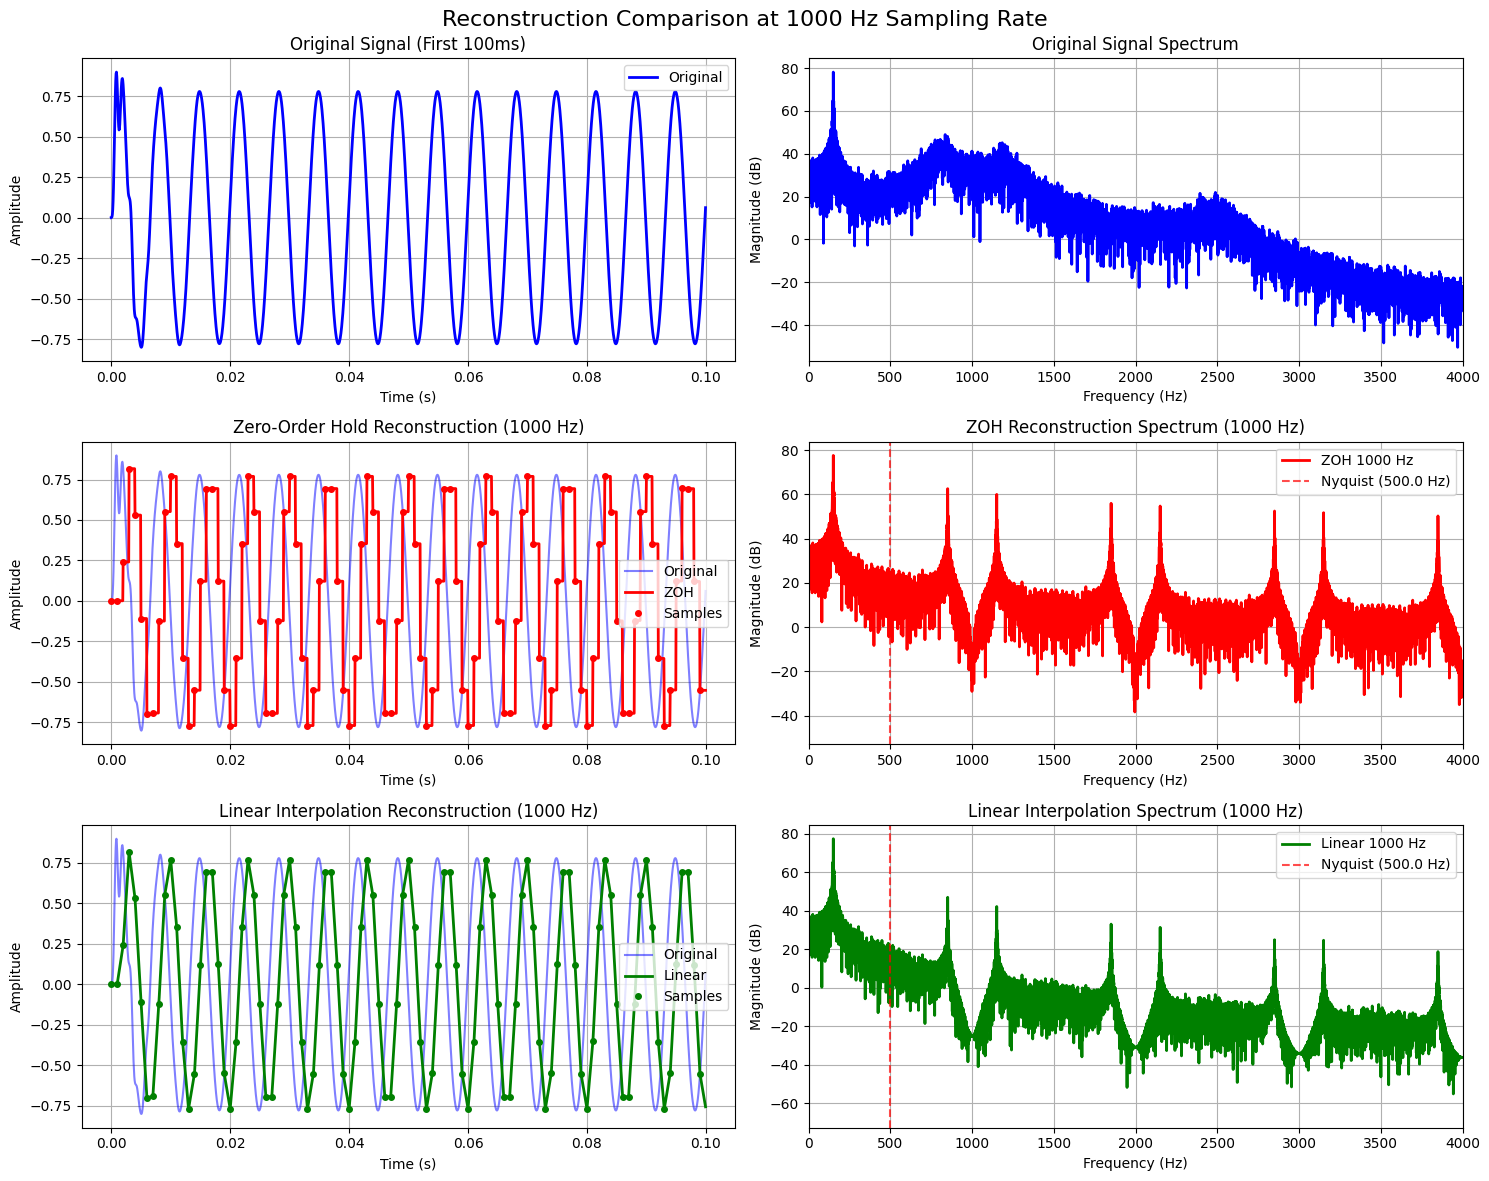

Completed analysis for 1000 Hz sampling rate
--------------------------------------------------


In [18]:
# Compare reconstruction methods for different sampling rates
fs_compare_list = [8000, 4000, 2000, 1000]

# Create a figure for each sampling rate
for fs_compare in fs_compare_list:
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Time domain comparison (first 100ms)
    duration_100ms = 0.1
    samples_100ms_orig = int(duration_100ms * fs_orig)
    samples_100ms_recon = int(duration_100ms * fs_orig)
    
    # Original signal
    axes[0, 0].plot(t_orig[:samples_100ms_orig], speech_signal[:samples_100ms_orig], 'b-', linewidth=2, label='Original')
    axes[0, 0].set_title('Original Signal (First 100ms)')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True)
    axes[0, 0].legend()
    
    # ZOH reconstruction
    axes[1, 0].plot(t_orig[:samples_100ms_orig], speech_signal[:samples_100ms_orig], 'b-', alpha=0.5, label='Original')
    axes[1, 0].plot(zoh_time_vectors[fs_compare][:samples_100ms_recon], 
                    zoh_reconstructed[fs_compare][:samples_100ms_recon], 'r-', linewidth=2, label='ZOH')
    # Show sample points
    sample_indices = np.arange(0, int(duration_100ms * fs_compare))
    axes[1, 0].plot(time_vectors[fs_compare][sample_indices], 
                    sampled_signals[fs_compare][sample_indices], 'ro', markersize=4, label='Samples')
    axes[1, 0].set_title(f'Zero-Order Hold Reconstruction ({fs_compare} Hz)')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].grid(True)
    axes[1, 0].legend()
    
    # Linear interpolation reconstruction
    axes[2, 0].plot(t_orig[:samples_100ms_orig], speech_signal[:samples_100ms_orig], 'b-', alpha=0.5, label='Original')
    axes[2, 0].plot(linear_time_vectors[fs_compare][:samples_100ms_recon], 
                    linear_reconstructed[fs_compare][:samples_100ms_recon], 'g-', linewidth=2, label='Linear')
    axes[2, 0].plot(time_vectors[fs_compare][sample_indices], 
                    sampled_signals[fs_compare][sample_indices], 'go', markersize=4, label='Samples')
    axes[2, 0].set_title(f'Linear Interpolation Reconstruction ({fs_compare} Hz)')
    axes[2, 0].set_xlabel('Time (s)')
    axes[2, 0].set_ylabel('Amplitude')
    axes[2, 0].grid(True)
    axes[2, 0].legend()
    
    # Frequency domain comparisons
    freqs_orig = np.fft.fftfreq(len(speech_signal), 1/fs_orig)
    fft_orig = np.fft.fft(speech_signal)
    
    freqs_zoh = np.fft.fftfreq(len(zoh_reconstructed[fs_compare]), 1/fs_orig)
    fft_zoh = np.fft.fft(zoh_reconstructed[fs_compare])
    
    freqs_linear = np.fft.fftfreq(len(linear_reconstructed[fs_compare]), 1/fs_orig)
    fft_linear = np.fft.fft(linear_reconstructed[fs_compare])
    
    # Original signal spectrum
    axes[0, 1].plot(freqs_orig[:len(freqs_orig)//2], 20*np.log10(np.abs(fft_orig[:len(freqs_orig)//2])), 'b-', linewidth=2)
    axes[0, 1].set_title('Original Signal Spectrum')
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('Magnitude (dB)')
    axes[0, 1].set_xlim([0, 4000])
    axes[0, 1].grid(True)
    
    # ZOH reconstruction spectrum
    axes[1, 1].plot(freqs_zoh[:len(freqs_zoh)//2], 20*np.log10(np.abs(fft_zoh[:len(freqs_zoh)//2])), 'r-', linewidth=2, label=f'ZOH {fs_compare} Hz')
    axes[1, 1].set_title(f'ZOH Reconstruction Spectrum ({fs_compare} Hz)')
    axes[1, 1].set_xlabel('Frequency (Hz)')
    axes[1, 1].set_ylabel('Magnitude (dB)')
    axes[1, 1].set_xlim([0, 4000])
    axes[1, 1].axvline(fs_compare/2, color='red', linestyle='--', alpha=0.7, label=f'Nyquist ({fs_compare/2} Hz)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # Linear interpolation spectrum
    axes[2, 1].plot(freqs_linear[:len(freqs_linear)//2], 20*np.log10(np.abs(fft_linear[:len(freqs_linear)//2])), 'g-', linewidth=2, label=f'Linear {fs_compare} Hz')
    axes[2, 1].set_title(f'Linear Interpolation Spectrum ({fs_compare} Hz)')
    axes[2, 1].set_xlabel('Frequency (Hz)')
    axes[2, 1].set_ylabel('Magnitude (dB)')
    axes[2, 1].set_xlim([0, 4000])
    axes[2, 1].axvline(fs_compare/2, color='red', linestyle='--', alpha=0.7, label=f'Nyquist ({fs_compare/2} Hz)')
    axes[2, 1].legend()
    axes[2, 1].grid(True)
    
    plt.suptitle(f'Reconstruction Comparison at {fs_compare} Hz Sampling Rate', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"Completed analysis for {fs_compare} Hz sampling rate")
    print("-" * 50)

In [19]:
def analyze_source_filter_model(speech_signal, fs, frame_length_ms=25, frame_shift_ms=10):
    """
    Analyze speech using source-filter model
    """
    frame_length = int(frame_length_ms * fs / 1000)
    frame_shift = int(frame_shift_ms * fs / 1000)
    
    # Initialize arrays
    num_frames = (len(speech_signal) - frame_length) // frame_shift + 1
    pitch_contour = np.zeros(num_frames)
    formant_frequencies = np.zeros((num_frames, 3))  # F1, F2, F3
    
    for frame_idx in range(num_frames):
        start = frame_idx * frame_shift
        end = start + frame_length
        frame = speech_signal[start:end]
        
        # Apply window
        windowed_frame = frame * np.hanning(len(frame))
        
        # Pitch estimation using autocorrelation
        autocorr = np.correlate(windowed_frame, windowed_frame, mode='full')
        autocorr = autocorr[autocorr.size // 2:]
        
        # Find pitch period (skip first peak at lag 0)
        min_pitch_lag = int(fs / 500)  # 500 Hz max pitch
        max_pitch_lag = int(fs / 80)   # 80 Hz min pitch
        
        if max_pitch_lag < len(autocorr):
            pitch_autocorr = autocorr[min_pitch_lag:max_pitch_lag]
            if len(pitch_autocorr) > 0:
                pitch_lag = np.argmax(pitch_autocorr) + min_pitch_lag
                pitch_contour[frame_idx] = fs / pitch_lag
        
        # Formant estimation using LPC
        try:
            # Linear Predictive Coding analysis
            lpc_order = int(2 + fs / 1000)  # Rule of thumb: 2 + fs/1000
            if len(windowed_frame) > lpc_order:
                lpc_coeffs = librosa.lpc(windowed_frame, order=lpc_order)
                
                # Find roots of LPC polynomial
                roots = np.roots(lpc_coeffs)
                
                # Extract formant frequencies from complex roots
                angles = np.angle(roots)
                frequencies = angles * fs / (2 * np.pi)
                
                # Keep only positive frequencies and sort
                positive_freqs = frequencies[frequencies > 0]
                positive_freqs = np.sort(positive_freqs)
                
                # Extract first 3 formants
                for i in range(min(3, len(positive_freqs))):
                    if positive_freqs[i] < fs/2:  # Below Nyquist
                        formant_frequencies[frame_idx, i] = positive_freqs[i]
        except:
            pass  # Handle cases where LPC fails
    
    # Time vector for frames
    frame_times = np.arange(num_frames) * frame_shift_ms / 1000
    
    return frame_times, pitch_contour, formant_frequencies

# Analyze original and reconstructed signals
fs_analysis = 8000  # Use 8kHz sampling rate for analysis

# Analyze original signal (downsampled to 8kHz for comparison)
orig_8k = signal.resample_poly(speech_signal, 8000, fs_orig)
frame_times, pitch_orig, formants_orig = analyze_source_filter_model(orig_8k, 8000)

# Analyze ZOH reconstructed signal
_, pitch_zoh, formants_zoh = analyze_source_filter_model(
    signal.resample_poly(zoh_reconstructed[8000], 8000, fs_orig), 8000)

# Analyze Linear reconstructed signal  
_, pitch_linear, formants_linear = analyze_source_filter_model(
    signal.resample_poly(linear_reconstructed[8000], 8000, fs_orig), 8000)

print("Source-filter analysis completed!")

Source-filter analysis completed!


Visualize Source-Filter Analysis

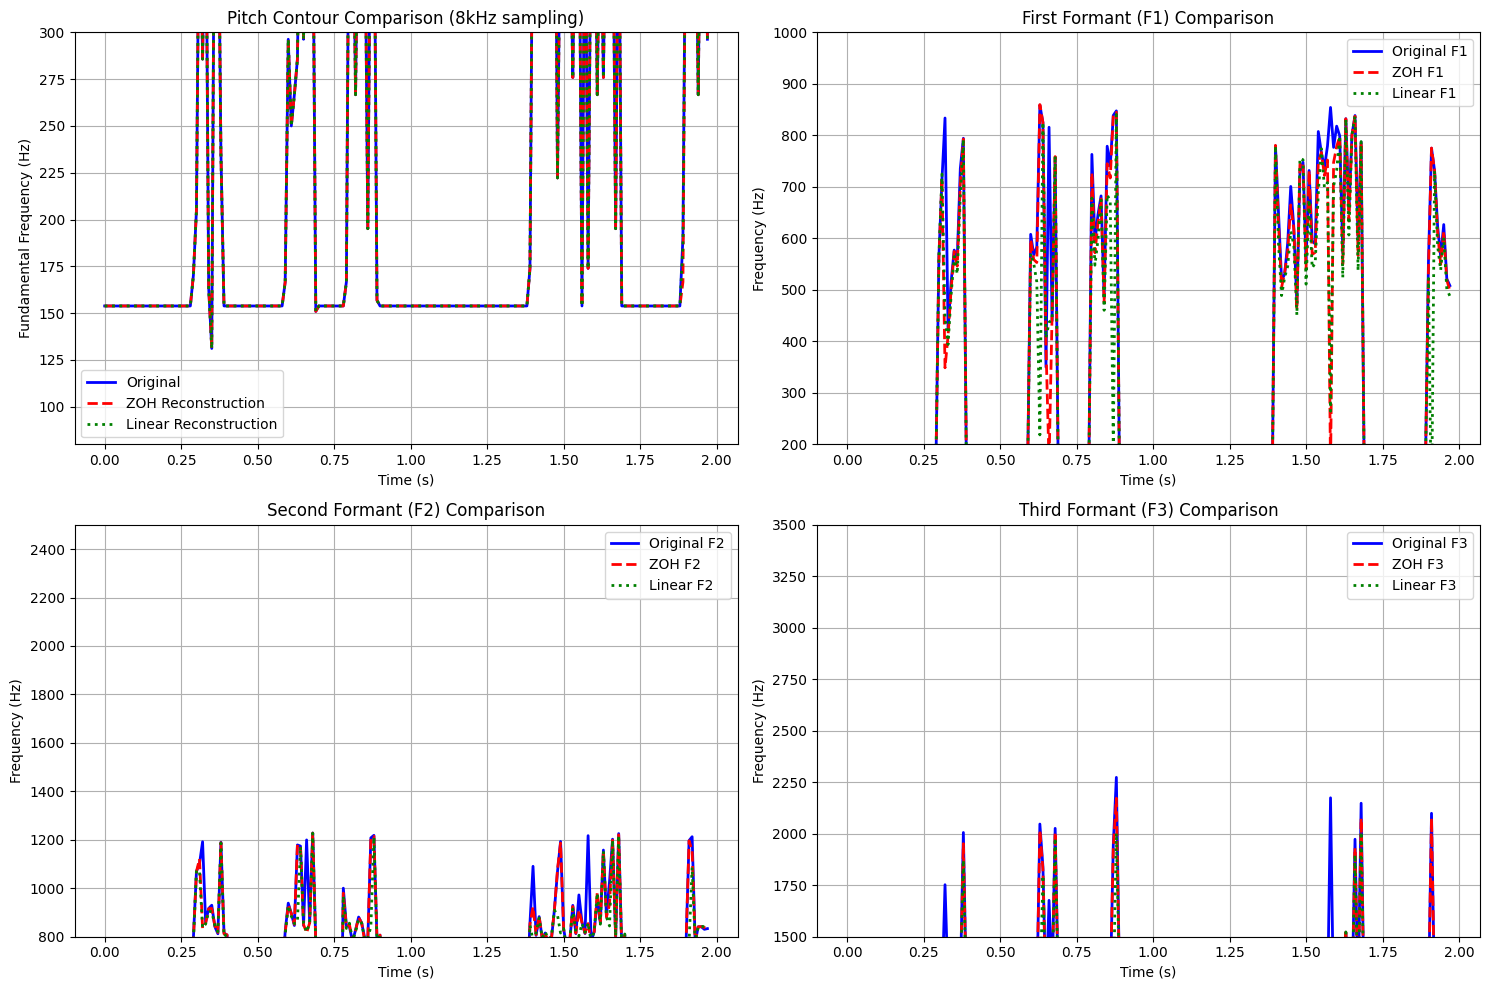

In [20]:
# Plot source-filter analysis results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Pitch contour comparison
axes[0, 0].plot(frame_times, pitch_orig, 'b-', linewidth=2, label='Original')
axes[0, 0].plot(frame_times, pitch_zoh, 'r--', linewidth=2, label='ZOH Reconstruction')
axes[0, 0].plot(frame_times, pitch_linear, 'g:', linewidth=2, label='Linear Reconstruction')
axes[0, 0].set_title('Pitch Contour Comparison (8kHz sampling)')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Fundamental Frequency (Hz)')
axes[0, 0].set_ylim([80, 300])
axes[0, 0].legend()
axes[0, 0].grid(True)

# Formant trajectory comparison (F1)
axes[0, 1].plot(frame_times, formants_orig[:, 0], 'b-', linewidth=2, label='Original F1')
axes[0, 1].plot(frame_times, formants_zoh[:, 0], 'r--', linewidth=2, label='ZOH F1')
axes[0, 1].plot(frame_times, formants_linear[:, 0], 'g:', linewidth=2, label='Linear F1')
axes[0, 1].set_title('First Formant (F1) Comparison')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Frequency (Hz)')
axes[0, 1].set_ylim([200, 1000])
axes[0, 1].legend()
axes[0, 1].grid(True)

# Formant trajectory comparison (F2)
axes[1, 0].plot(frame_times, formants_orig[:, 1], 'b-', linewidth=2, label='Original F2')
axes[1, 0].plot(frame_times, formants_zoh[:, 1], 'r--', linewidth=2, label='ZOH F2')
axes[1, 0].plot(frame_times, formants_linear[:, 1], 'g:', linewidth=2, label='Linear F2')
axes[1, 0].set_title('Second Formant (F2) Comparison')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Frequency (Hz)')
axes[1, 0].set_ylim([800, 2500])
axes[1, 0].legend()
axes[1, 0].grid(True)

# Formant trajectory comparison (F3)
axes[1, 1].plot(frame_times, formants_orig[:, 2], 'b-', linewidth=2, label='Original F3')
axes[1, 1].plot(frame_times, formants_zoh[:, 2], 'r--', linewidth=2, label='ZOH F3')
axes[1, 1].plot(frame_times, formants_linear[:, 2], 'g:', linewidth=2, label='Linear F3')
axes[1, 1].set_title('Third Formant (F3) Comparison')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Frequency (Hz)')
axes[1, 1].set_ylim([1500, 3500])
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

Quality Analysis

In [21]:
def calculate_snr(original, reconstructed):
    """Calculate Signal-to-Noise Ratio"""
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - reconstructed) ** 2)
    
    if noise_power == 0:
        return float('inf')
    return 10 * np.log10(signal_power / noise_power)

def calculate_thd(signal, fs):
    """Calculate Total Harmonic Distortion"""
    # Find fundamental frequency
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/fs)
    
    # Find peak frequency (fundamental)
    positive_freqs = freqs[:len(freqs)//2]
    magnitude = np.abs(fft_signal[:len(freqs)//2])
    fundamental_idx = np.argmax(magnitude[10:]) + 10  # Skip DC component
    fundamental_freq = positive_freqs[fundamental_idx]
    
    # Calculate harmonics
    fundamental_power = magnitude[fundamental_idx] ** 2
    harmonic_power = 0
    
    for harmonic in range(2, 6):  # 2nd to 5th harmonics
        harmonic_freq = harmonic * fundamental_freq
        if harmonic_freq < fs/2:
            harmonic_idx = np.argmin(np.abs(positive_freqs - harmonic_freq))
            harmonic_power += magnitude[harmonic_idx] ** 2
    
    if fundamental_power == 0:
        return 0
    return np.sqrt(harmonic_power / fundamental_power) * 100

def calculate_spectral_distortion(original, reconstructed, fs):
    """Calculate spectral distortion"""
    # Compute power spectral densities
    f_orig, psd_orig = signal.welch(original, fs, nperseg=512)
    f_recon, psd_recon = signal.welch(reconstructed, fs, nperseg=512)
    
    # Interpolate to same frequency grid
    psd_recon_interp = np.interp(f_orig, f_recon, psd_recon)
    
    # Calculate log spectral distortion
    lsd = np.mean((10 * np.log10(psd_orig + 1e-10) - 10 * np.log10(psd_recon_interp + 1e-10)) ** 2)
    return np.sqrt(lsd)

# Calculate quality metrics
quality_metrics = {}

for fs in sampling_rates:
    # Ensure signals have same length for comparison
    min_length = min(len(speech_signal), len(zoh_reconstructed[fs]), len(linear_reconstructed[fs]))
    
    orig_truncated = speech_signal[:min_length]
    zoh_truncated = zoh_reconstructed[fs][:min_length]
    linear_truncated = linear_reconstructed[fs][:min_length]
    
    quality_metrics[fs] = {
        'zoh_snr': calculate_snr(orig_truncated, zoh_truncated),
        'linear_snr': calculate_snr(orig_truncated, linear_truncated),
        'zoh_thd': calculate_thd(zoh_truncated, fs_orig),
        'linear_thd': calculate_thd(linear_truncated, fs_orig),
        'zoh_spectral_dist': calculate_spectral_distortion(orig_truncated, zoh_truncated, fs_orig),
        'linear_spectral_dist': calculate_spectral_distortion(orig_truncated, linear_truncated, fs_orig)
    }

# Display quality metrics
print("Quality Metrics Summary:")
print("=" * 60)
print(f"{'Sampling Rate':<12} {'Method':<8} {'SNR (dB)':<10} {'THD (%)':<10} {'Spectral Dist':<15}")
print("=" * 60)

for fs in sampling_rates:
    metrics = quality_metrics[fs]
    print(f"{fs:<12} {'ZOH':<8} {metrics['zoh_snr']:<10.2f} {metrics['zoh_thd']:<10.2f} {metrics['zoh_spectral_dist']:<15.2f}")
    print(f"{'':<12} {'Linear':<8} {metrics['linear_snr']:<10.2f} {metrics['linear_thd']:<10.2f} {metrics['linear_spectral_dist']:<15.2f}")
    print("-" * 60)

Quality Metrics Summary:
Sampling Rate Method   SNR (dB)   THD (%)    Spectral Dist  
8000         ZOH      9.59       1.40       15.47          
             Linear   13.13      1.30       6.83           
------------------------------------------------------------
4000         ZOH      3.78       1.48       23.67          
             Linear   5.75       1.34       11.50          
------------------------------------------------------------
2000         ZOH      0.50       1.33       23.94          
             Linear   2.44       1.03       11.17          
------------------------------------------------------------
1000         ZOH      -4.24      0.24       20.67          
             Linear   -2.35      0.17       13.52          
------------------------------------------------------------
